## Google-Symptoms DAP_01_24

Analyst: Jingjing

Advisors: Jacob and Nat

Stackholder: Ryan and Nigam


In [81]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import re
from itertools import product
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from scipy.stats import spearmanr, rankdata
import seaborn as sns

import pandas as pd
import numpy as np

import covidcast
from delphi_utils import GeoMapper


gmpr = GeoMapper()

## Introduction

Google Symptoms is a new symptom search dataset provided by Google, reporting normalized per-capita search topic popularity. Google maps all search queries to 422 symptoms either COVID-19 related or not. Delphi has already released multiple signals based on "Anosmia" and "Ageusia" search popularities to the public. Though useful, they have extremely low geographical coverage which causes the problem in supporting forecasting work. In this DAP, we are eager to explore more COVID-19 related symptoms and create new indicators that can maintain the same level of predictive power but obtain better geographical coverage.

We adopted the recommendation made in Addison's [report](https://htmlpreview.github.io/?https://github.com/cmu-delphi/covidcast-modeling/blob/main/indicator_heterogeneity_I/reports/DAP_Report_IndicatorHeterogeneity.html#ground-truth-hospitalizations-data) for the Indicator Heterogeneity I: Regression Models DAP to conduct static sensorization to use static sensorization method for indicator correction. The google symptoms dataset we used was updated on 12-14-2020, the most recent data in this dataset is for 12-08-2020. The target data we used for both correlation analysis and predictive power analysis are smoothed confirmed case incidence rates provided by USA-Facts with `as_of date = 2020-12-14`.  

## Methods

- Selection of Symptom Sets
- Missingness
- Sensorization
   - Based on raw sum of symptoms within symptom sets
   - Based on regression 

### Selection of Symptom Sets

We are provided with 422 google search symptoms in total without mapping information from the raw search queries to the symptoms. In order to create a limited number of COVID indicators, we filtered COVID-related symptoms according to symptom terms highlighted by CDC and electrical heath records offered by Nigan ([here](https://docs.google.com/spreadsheets/d/1IabaTn4wkrlcTAkyiCYCeSHgjmzhSu3WWQNGte0seJE/edit#gid=0)) and divided them into 6 non-overlapping symptom sets ([here](https://docs.google.com/document/d/1fFS2wF6G1dfR62RdMTJ6KwSMsr8Ou6tLVewUbYGHAEk/edit)). The symptoms sets selected are listed below.

In [2]:
symptom_sets = {
    "Respiratory": ["symptom:Cough", "symptom:Phlegm", "symptom:Shortness of breath", "symptom:Wheeze",
                        "symptom:Asthma", "symptom:Pneumonia", "symptom:Sore throat"],
    "Sensory": ["symptom:Anosmia", "symptom:Dysgeusia", "symptom:Ageusia"],
    "Fever": ["symptom:Fever", "symptom:Hyperthermia", "symptom:Chills", "symptom:Shivering"],
    "Fatigue": ["symptom:Fatigue", "symptom:Weakness"],
    "GI": ["symptom:Nausea", "symptom:Vomiting", "symptom:Diarrhea", "symptom:Indigestion",
          "symptom:Abdominal pain"],
    "Pain": ["symptom:Pain", "symptom:Sharp pain", "symptom:Chest pain", "symptom:Myalgia",
             "symptom:Arthralgia", "symptom:Eye pain", "symptom:Headache", "symptom:Migraine",
             "symptom:Cramp"]
}
for set_name in symptom_sets.keys():
    print("- %s:"%set_name)
    for gs in symptom_sets[set_name]:
        print(gs)
    print("\n")

- Respiratory:
symptom:Cough
symptom:Phlegm
symptom:Shortness of breath
symptom:Wheeze
symptom:Asthma
symptom:Pneumonia
symptom:Sore throat


- Sensory:
symptom:Anosmia
symptom:Dysgeusia
symptom:Ageusia


- Fever:
symptom:Fever
symptom:Hyperthermia
symptom:Chills
symptom:Shivering


- Fatigue:
symptom:Fatigue
symptom:Weakness


- GI:
symptom:Nausea
symptom:Vomiting
symptom:Diarrhea
symptom:Indigestion
symptom:Abdominal pain


- Pain:
symptom:Pain
symptom:Sharp pain
symptom:Chest pain
symptom:Myalgia
symptom:Arthralgia
symptom:Eye pain
symptom:Headache
symptom:Migraine
symptom:Cramp




### Missingness

We adopted two methods to deal with missingness before computing the smoothed version using 7-day moving average for each selected symptoms: 

- 1) fill0: simply fill 0s in; 
- 2) fillminratio: where we assume that the county's missing value was 1/2 of what the minimum county in that states was in terms of its ratio relative to a historical average. In this method, we first computed the ratio for every county (c) in a certain state (s) for a certain date (t): $$r_{c, t} =\frac{ Y_{c, t} }{ \text{historical-average}(Y_c)}$$
where $Y_{c, t}$ is the raw value for a county c on date t, $r_{c, t}$ is the computed ratio, historical-average$(Y_{c})$ is computed based on raw values from the first date (2020-02-20) to date t. Then, we found the smallest ratio for state (s) and for each date (t) which is named to be $rmin_{s, t}$. Finally, the missed values will be filled with $$Y_{c, t} = \text{historical-average}(Y_{c}) \times \frac{1}{2} \times rmin_{s, t}$$
Notice that, this method will help counties with some dates available but won't help with counties with no data available at all. 

The violin plots below show the comparison between the raw dataset and the dataset will fillminratio methods conducted. The fillminratio methods help push counties above line 0 (have some dates available) to line 1 (have all dates available). But it has nothing to do with counties having no data available at all (counties at line 0 will stay at line 0). In general, these two methods provide a starting point for smoothing.

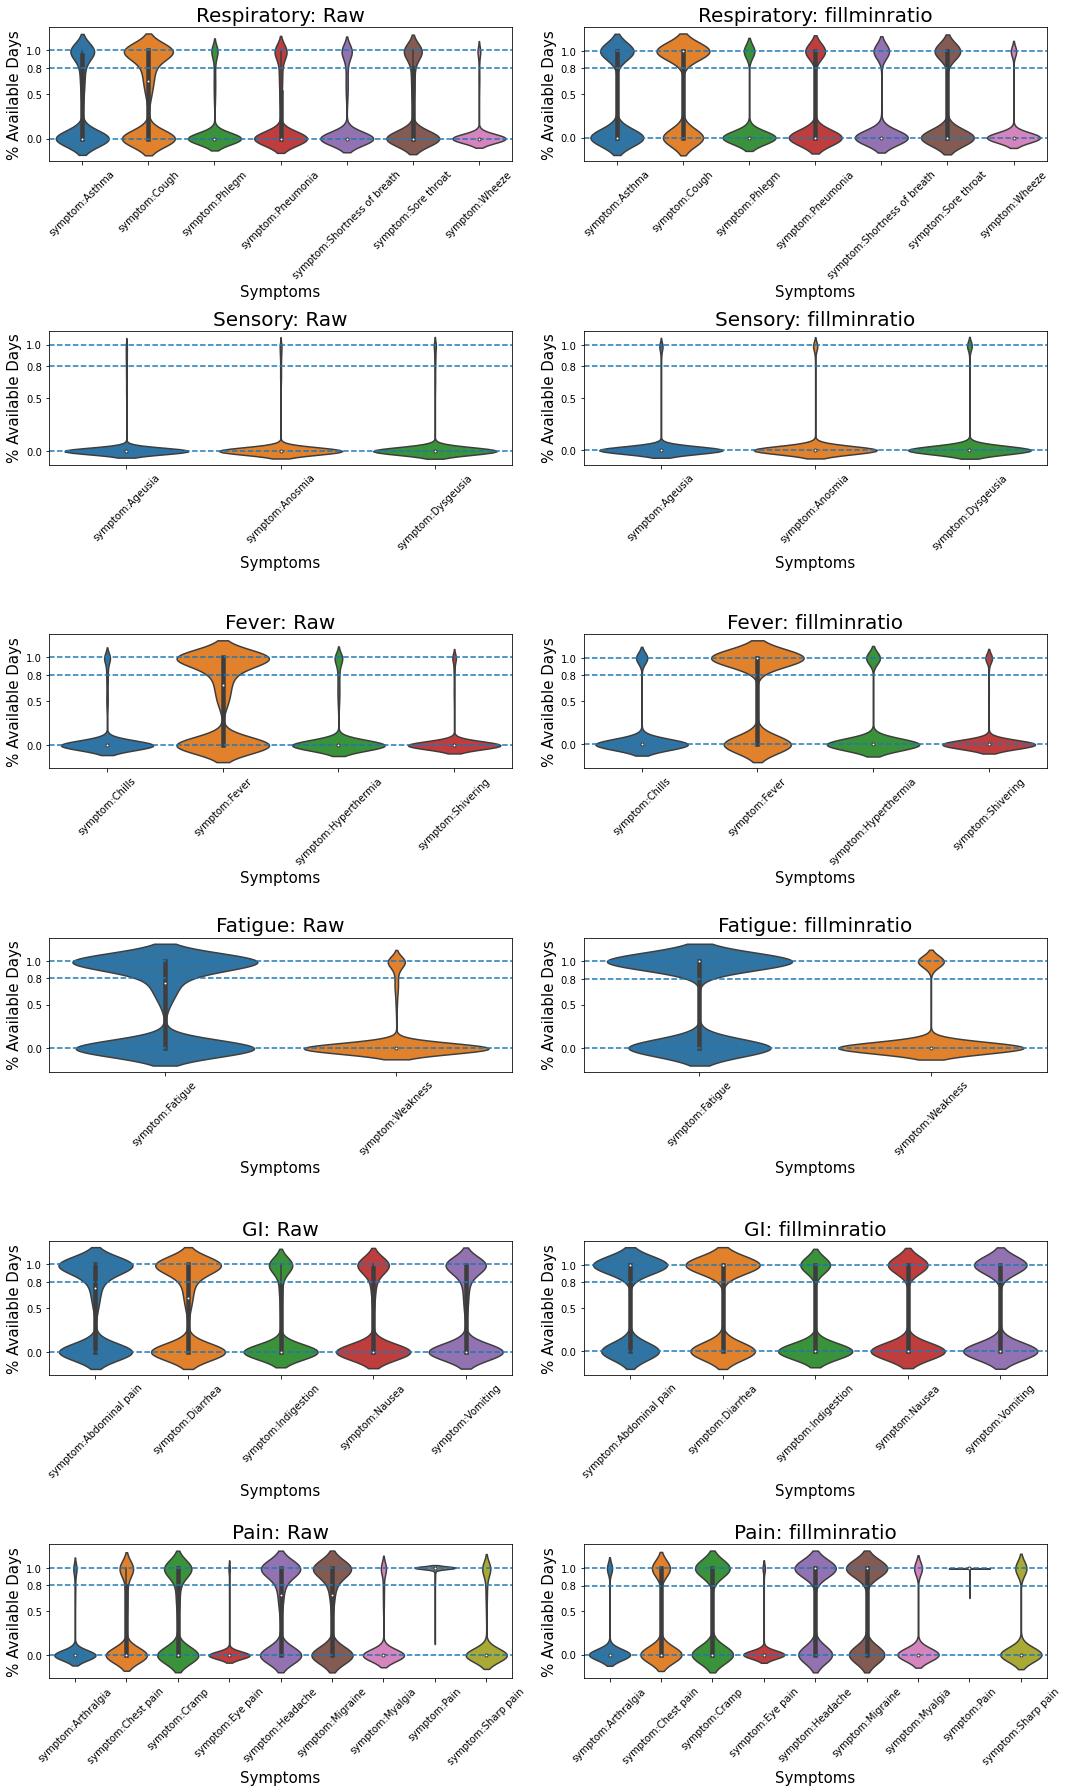

In [4]:
gs_df = pd.read_csv("./raw/county_google_symptoms_12_14.csv", parse_dates=["date"])
gs_df = gs_df.loc[~gs_df["geo_id"].isnull()]
gs_df["geo_id"] = [str(int(x)).zfill(5) for x in gs_df["geo_id"]]
gs_df = gs_df[gs_df["date"] >= datetime(2020, 2, 20)]
n_days_fill0 = (gs_df["date"].max() - gs_df["date"].min()).days + 1
summary_df_fill0 = (1- gs_df.set_index("geo_id").isnull().groupby("geo_id").sum() / n_days_fill0).reset_index().drop("date", axis=1)
summary_df_fill0 = pd.melt(summary_df_fill0,
            id_vars="geo_id", 
            value_vars=list(summary_df_fill0.columns[1:]), # list of days of the week
            var_name='symptoms', 
            value_name='%available_days')


gs_df = pd.read_csv("./raw/county_fillminratio_raw_google_symptoms_12_14.csv", parse_dates=["date"])
gs_df["geo_id"] = [str(int(x)).zfill(5) for x in gs_df["geo_id"]]
gs_df = gs_df[gs_df["date"] >= datetime(2020, 2, 20)]
n_days_fillminratio = (gs_df["date"].max() - gs_df["date"].min()).days + 1
summary_df_fillminratio = (1- gs_df.set_index("geo_id").isnull().groupby("geo_id").sum() / n_days_fillminratio).reset_index().drop("date", axis=1)
summary_df_fillminratio = pd.melt(summary_df_fillminratio,
            id_vars="geo_id", 
            value_vars=list(summary_df_fillminratio.columns[1:]), # list of days of the week
            var_name='symptoms', 
            value_name='%available_days')
summary_df_fillminratio = summary_df_fillminratio.sort_values("symptoms")


planets = sns.load_dataset("planets")
# Violin plot of number of available days for each symptom in each county

plt.figure(figsize=(15, 25))
i=1
for setn in symptom_sets.keys():
    plt.subplot(6, 2, i)
    i += 1
    sns.violinplot(x="symptoms", y="%available_days", 
                   scale="count", data=summary_df_fill0[summary_df_fill0["symptoms"].isin(symptom_sets[setn])])
    plt.title(setn + ": Raw", fontsize=20)
    plt.xticks(rotation = 45)
    plt.xlabel("Symptoms", fontsize=15)
    plt.axhline(0, linestyle="--")
    plt.axhline(1, linestyle="--")
    plt.axhline(0.8, linestyle="--")
    plt.yticks([0, 0.5, 0.8, 1.0])
    plt.ylabel("% Available Days", fontsize=15)
    
    plt.subplot(6, 2, i)
    i += 1
    sns.violinplot(x="symptoms", y="%available_days", 
                   scale="count", data=summary_df_fillminratio[summary_df_fillminratio["symptoms"].isin(symptom_sets[setn])])
    plt.title(setn + ": fillminratio", fontsize=20)
    plt.xticks(rotation = 45)
    plt.xlabel("Symptoms", fontsize=15)
    plt.axhline(0, linestyle="--")
    plt.axhline(1, linestyle="--")
    plt.axhline(0.8, linestyle="--")
    plt.yticks([0, 0.5, 0.8, 1.0])
    plt.ylabel("% Available Days", fontsize=15)
plt.tight_layout()

### Sensorization

Here we use a spatial only, static sensorization as described in [Addison's report](https://htmlpreview.github.io/?https://github.com/cmu-delphi/covidcast-modeling/blob/main/indicator_heterogeneity_I/reports/DAP_Report_IndicatorHeterogeneity.html) for the Indicator Heterogeneity I DAP. We ignore the possibility of temporal heterogeneity and learn a single linear relationship between the indicator and the target for each location. For each date (t) and each location (c), we train the linear regression model based on data from the first date (2020-02-20) to 7 days ago (t-7) 

$$y_c \sim x_c \Longrightarrow \text{Model}(c)$$

and use the coefficient and intercept returned by the linear regression model to make predictions of all the dates until date t. 

$$\tilde{x}_{tc} = \text{predict}(x_{tc}, \text{Model}(c))$$

Here we reduce the influence of backfilling by removing the data of the most recent 7 days from the training dataset. Besides, for each date t, the target data is fetched with the earliest as of date that guarantees all the dates on/before date t are available. This helps us to better simulate the actual situation. To better compare with doctor visits in predictive power analysis, we manually assign `as_of` date of the these sensored google symptoms indicators to be date t + 5 since currently the Google symptoms dataset is updated by Google randomly. Notice that, we don't control the intercept to be 0 since a 0 popularity of a symptom isn't necessarily equal to 0 case rates.

We use two methods to combine multiple symptoms within different symptom sets:
- rawsum: simply sum up the scaled popularity of symptoms considered within a symptom set
- regression: train multiple symptoms as features in sensorization

# Results

- Performance 
    - Geographical coverage
    - Time-wise correlations
    - Geo-wise correlation
    - Coefficients and Intercepts
    - Predictive power analysis

### Geographical Coverage

Either from the violin plots shown above or from the bar plots shown below, the number of counties with > 50% days available remains constant among different method sets in terms of filling missing and combing multiple symptoms. The geographical coverages are similar for all the symptom sets except for Sensory, which has only ~100 counties available, and Pain, which has ~2600 counties available. There are ~1400 counties covered by Fatigue, Fever, GI, and Respiratory.

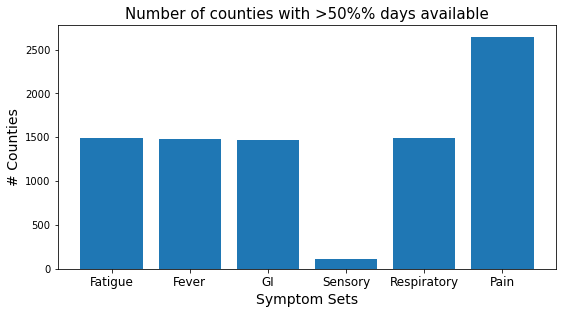

In [30]:
plt.figure(figsize = (15, 8))
i=1
for fillmissingness in ["fill0"]:
    for method in ["rawsum"]:
        signal_list = ["fatigue", "fever", "gi", "sensory", "respiratory", "pain"]
        plt.subplot(2, 2, i)
        i+=1
        
        geo_num = []
        for signal in signal_list:
            sensorization_df = pd.read_csv("./sensorization_with_as_of/sensored/%s_%s_%s_sensorization_12_14.csv"%(signal, method, fillmissingness), 
                                           parse_dates=["date"])
            geo_num.append(sensorization_df["geo_id"].unique().shape[0])
        plt.bar(signal_list, geo_num)
        plt.title("Number of counties with >50%% days available", fontsize=15)
        plt.xticks(["fatigue", "fever", "gi", "sensory", "respiratory", "pain"],
                   ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"], fontsize=12)
        plt.xlabel("Symptom Sets", fontsize=14)
        plt.ylabel("# Counties", fontsize=14)
        
plt.tight_layout()

### Time-wise Correlation Analysis

For each of our sensorized indicators, we compute time-wise correlations over a moving window of 6 weeks wide. For each date and each county, we compute the spearman rank correlation with smoothed case incidence data from USA-Facts. Notice that for a 6-week window ending with date t, the data considered are sensored by static sensorization which is trained on data from the earliest date (2020-02-20) to date t-7. This means the data we used for different time windows have different "as of date". On the contrary,  the target we use is the smoothed confirm case incidence rates provided by USA-Facts with as of date 2020-12-14.

In the line plots below, we show the median (solid lines) and 0.25 & 0.75 quantiles (filled area) of the correlations for each across all available counties for that indicator to reduce the dimension for visualization. **Notice that the list of available counties for different indicators can vary largely.** This can help explain why the lines for Sensory have stronger fluctuations.  In general, Sensory shows the best time-wise correlation again the target. As for the methods for dealing with missingness, filling 0 or using fillminratio method, which is a little bit more complicated as described above, does not make much difference which indicates us it's reasonable to just fill missing dates with 0. Comparatively, combining multiple symptoms within a symptom set using regression is better than simply computing the raw sum, but the benefit is not significant. Regression is 1.5-2 times more computational expansive than the raw sum which is acceptable.

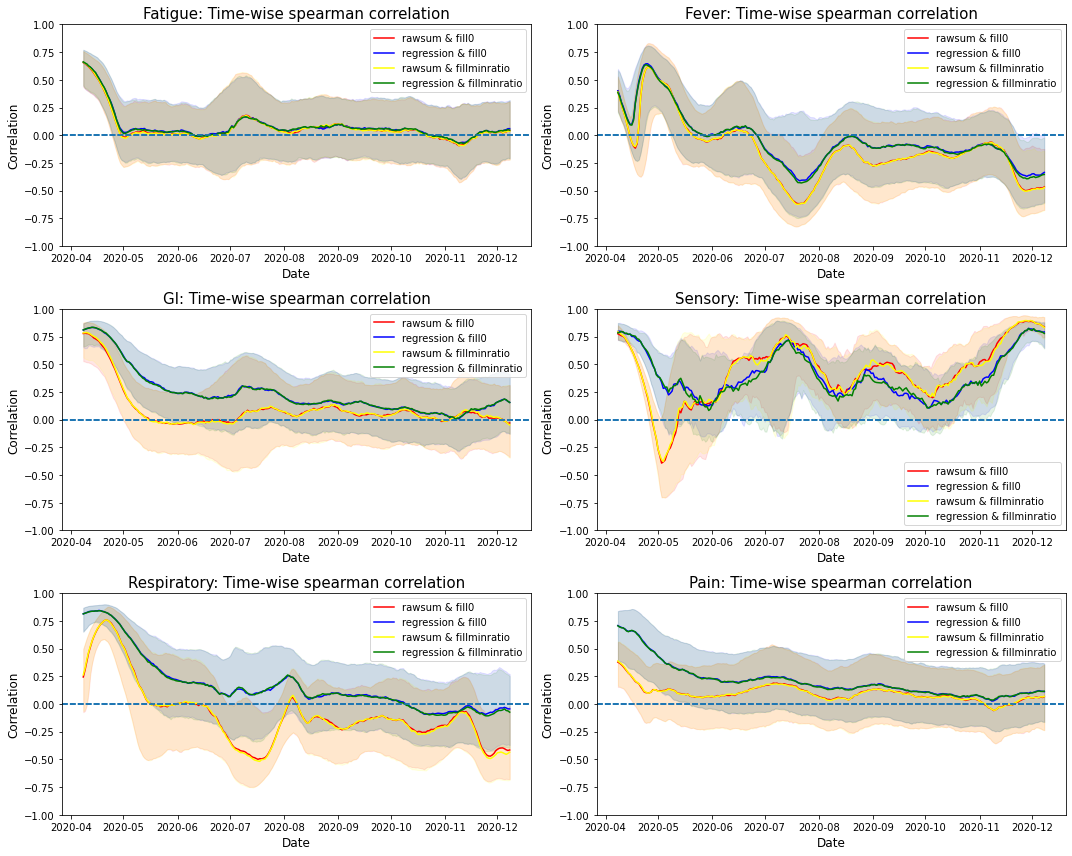

In [21]:
plt.figure(figsize = (15, 12))
i=1
color_dict = {("fill0", "rawsum"): "red",
              ("fill0", "regression"): "blue",
              ("fillminratio", "rawsum"): "yellow",
              ("fillminratio", "regression"): "green"}

signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
corr_dfs = {}
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    for fillmissingness in ["fill0", "fillminratio"]:
        corr_dfs[fillmissingness] = {}
        for method in ["rawsum", "regression"]:
            corr_dfs[fillmissingness][method] = {}
                    
            corr_dfs[fillmissingness][method][signal] = pd.read_csv("./sensorization_with_as_of/time_wise_corr/%s_corr_df_%s_%s.csv"%(signal,
                                                                                            method,
                                                                                            fillmissingness),
                                                                   parse_dates=["date"]) 
            corr_dfs[fillmissingness][method][signal]["county"] = [str(x).zfill(5) for x in corr_dfs[fillmissingness][method][signal]["county"]]

            current_df = corr_dfs[fillmissingness][method][signal]
            plot_df = current_df.groupby("date")["correlation"].median().reset_index()
            plot_75_df = current_df.groupby("date")["correlation"].quantile(0.75).reset_index()
            plot_25_df = current_df.groupby("date")["correlation"].quantile(0.25).reset_index()
            plt.plot(plot_df["date"], plot_df["correlation"], label="%s & %s"%(method, fillmissingness),
                    color = color_dict[(fillmissingness, method)])
            plt.fill_between(plot_df["date"], plot_75_df["correlation"], 
                             plot_25_df["correlation"],
                             color=color_dict[(fillmissingness, method)], alpha=0.1,
                             interpolate=True)          
            plt.title("%s: Time-wise spearman correlation"%signal, fontsize=15)
            plt.ylim((-1, 1))
            plt.xlabel("Date", fontsize=12)
            plt.ylabel("Correlation", fontsize=12)
            plt.axhline(0, linestyle="--")
            plt.legend()
            
plt.tight_layout()

### Geo-wise correlation Analysis

Remember that the raw dataset is scaled in a regionally specific manner which makes it incomparable across locations. A benefit of sensorization is that now it makes sense to consider the geo-wise correlation of the indicators based on Google-symptoms. On the plots shown below, each point of a single line represents the geo-wise correlation again the target with as of date 2020-12-14, but the data of the sensored indicator has as of date equal to the current date. For example, for the point at date t, the data we used for the Fatigue indicator is predicted by linear regression models trained on data from the earliest date 2020-02-20 to date t-7 for each county.  

**Again, the lists of locations considered when calculating the geo-wise correlation for different indicators are different for different symptom sets.** This could explain why sensory stands out with stronger fluctuation. There are only ~100 counties considered for sensory but >1400 counties considered for other indicators. Similar as what can conclude from the time-wise correlation analysis, the methods for filling missingness does not make big influence. Besides, regression slightly outperforms raw sum for combing multiple symptoms. 

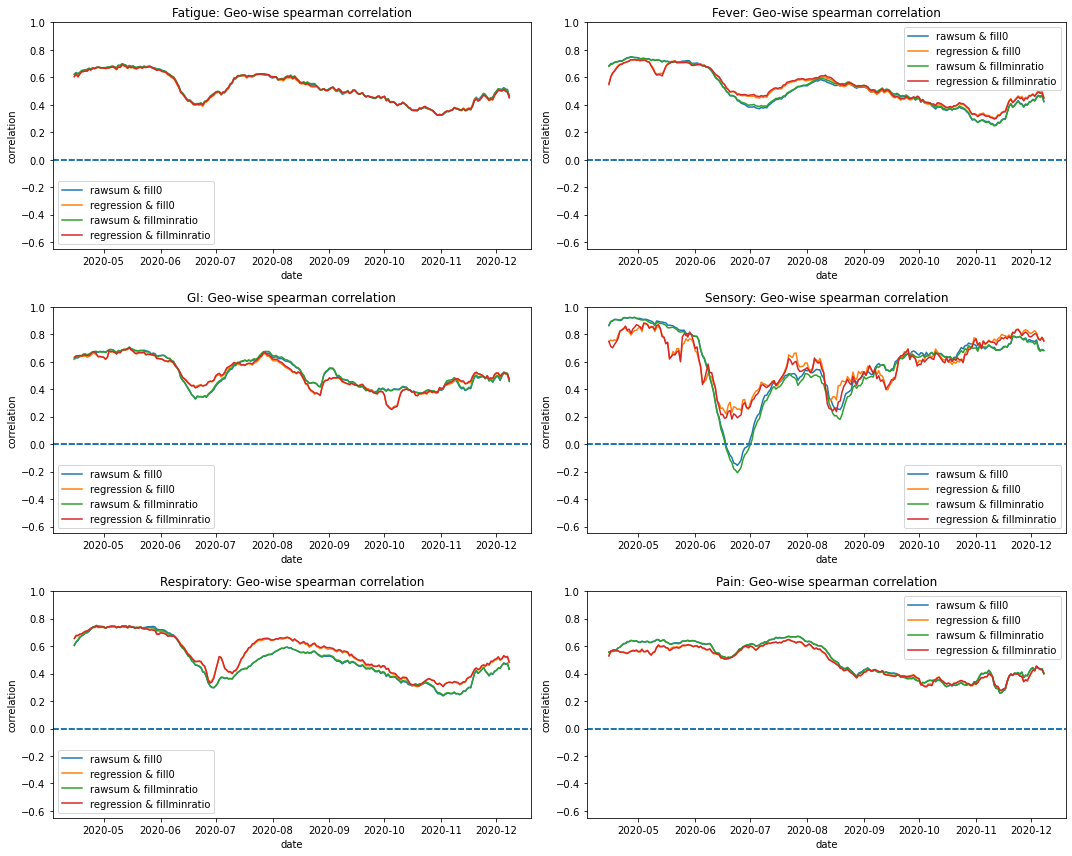

In [12]:
plt.figure(figsize = (15, 12))
i=1
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    for fillmissingness in ["fill0", "fillminratio"]:
        corr_dfs[fillmissingness] = {}
        for method in ["rawsum", "regression"]:
            corr_dfs[fillmissingness][method] = {}        
            corr_dfs[fillmissingness][method][signal] = pd.read_csv("./sensorization_with_as_of/geo_wise_varying_as_of/%s_static_geowise_corr_df_%s_%s.csv"%(signal.lower(),
                                                                                            method,
                                                                                            fillmissingness),
                                                                   parse_dates=["date"]) 
            corr_dfs[fillmissingness][method][signal] = corr_dfs[fillmissingness][method][signal].loc[
                corr_dfs[fillmissingness][method][signal]["date"] >= datetime(2020, 4, 15)
            ]
        
            current_df = corr_dfs[fillmissingness][method][signal]
            plt.plot(current_df["date"], current_df["correlation"], label="%s & %s"%(method, fillmissingness))
            plt.title("%s: Geo-wise spearman correlation"%signal)
            plt.ylim((-0.65, 1))
            plt.xlabel("Date")
            plt.ylabel("Correlation")
            plt.axhline(0, linestyle="--")
            plt.legend()
plt.tight_layout()

### Coefficients and Intercepts (consider fill0 only)
#### For rawsum

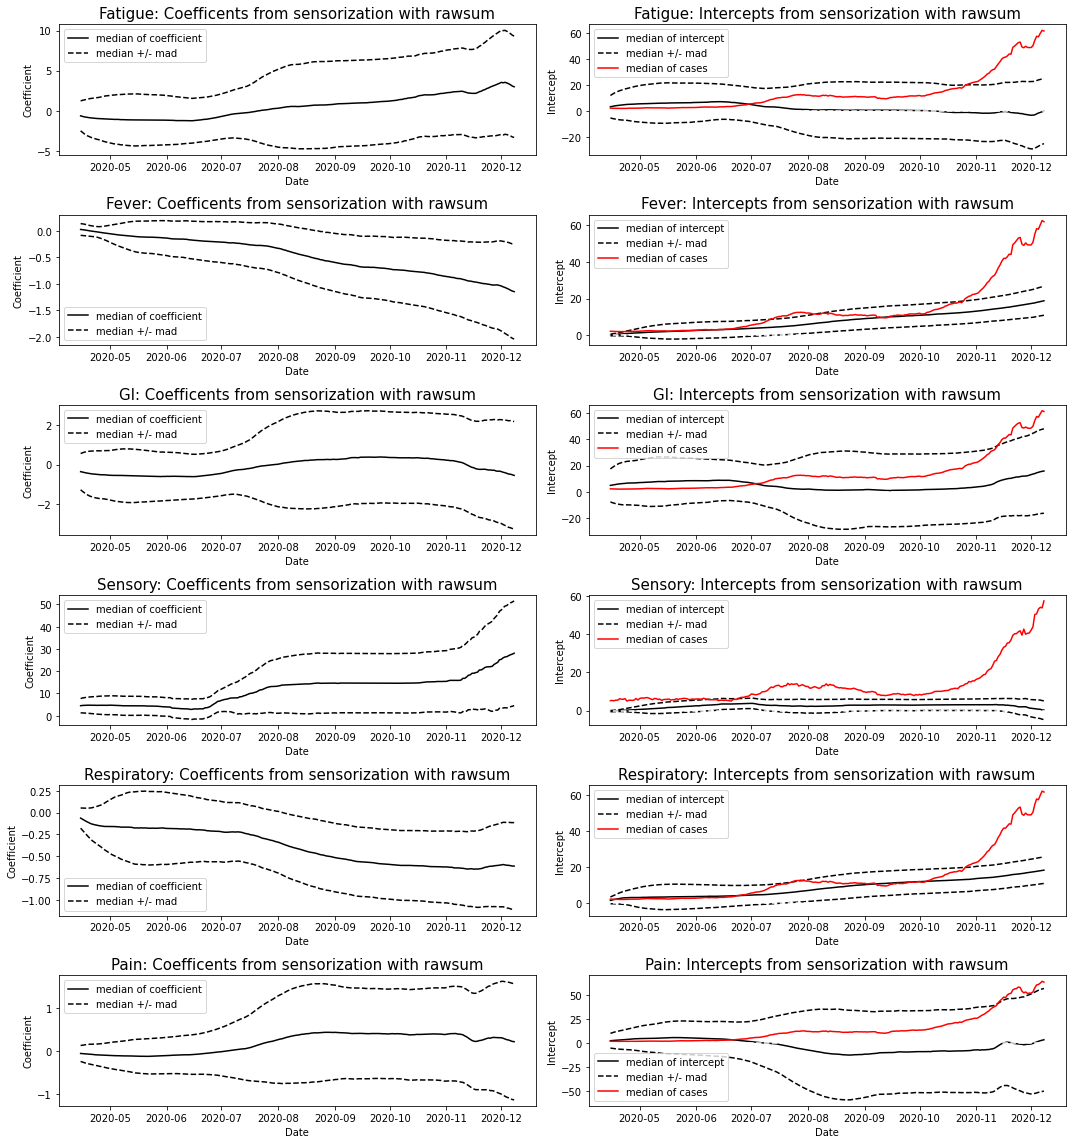

In [67]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize = (15, 16))
i=1
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
for signal in signal_list:
    # Read sensorization result
    df = pd.read_csv("./sensorization_with_as_of/sensored/%s_rawsum_fill0_sensorization_12_14.csv"%signal,
                    parse_dates=["date"])
    df = df.loc[df["date"] >= datetime(2020, 4, 15)]
    median_df = df.groupby("date").median().reset_index().drop(["geo_id"], axis=1)
    mad_df = df.groupby("date").mad().reset_index().drop(["geo_id"], axis=1)
    summary_df = median_df.merge(mad_df, on="date", suffixes=["_median", "_mad"])
    
    plt.subplot(6, 2, i)
    plt.plot(summary_df["date"], summary_df["coef_median"], color = "black", label="median of coefficient")
    plt.plot(summary_df["date"], summary_df["coef_median"] + summary_df["coef_mad"], 
             color = "black", linestyle = "--")
    plt.plot(summary_df["date"], summary_df["coef_median"] - summary_df["coef_mad"], 
             color = "black", label="median +/- mad", linestyle = "--")
    plt.title("%s: Coefficents from sensorization with rawsum"%signal, fontsize=15)
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Coefficient")
    
    plt.subplot(6, 2, i+1)
    plt.plot(summary_df["date"], summary_df["intercept_median"], color = "black", label="median of intercept")
    plt.plot(summary_df["date"], summary_df["intercept_median"] + summary_df["intercept_mad"], 
             color = "black", linestyle = "--")
    plt.plot(summary_df["date"], summary_df["intercept_median"] - summary_df["intercept_mad"], 
             color = "black", label="median +/- mad", linestyle = "--")
    plt.plot(summary_df["date"], summary_df["cases_median"], color = "red", label="median of cases")
    plt.title("%s: Intercepts from sensorization with rawsum"%signal, fontsize=15)
    plt.axhline(0, linestyle = "--", color = "white")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Intercept")
    i+=2
plt.tight_layout()    

#### For regression

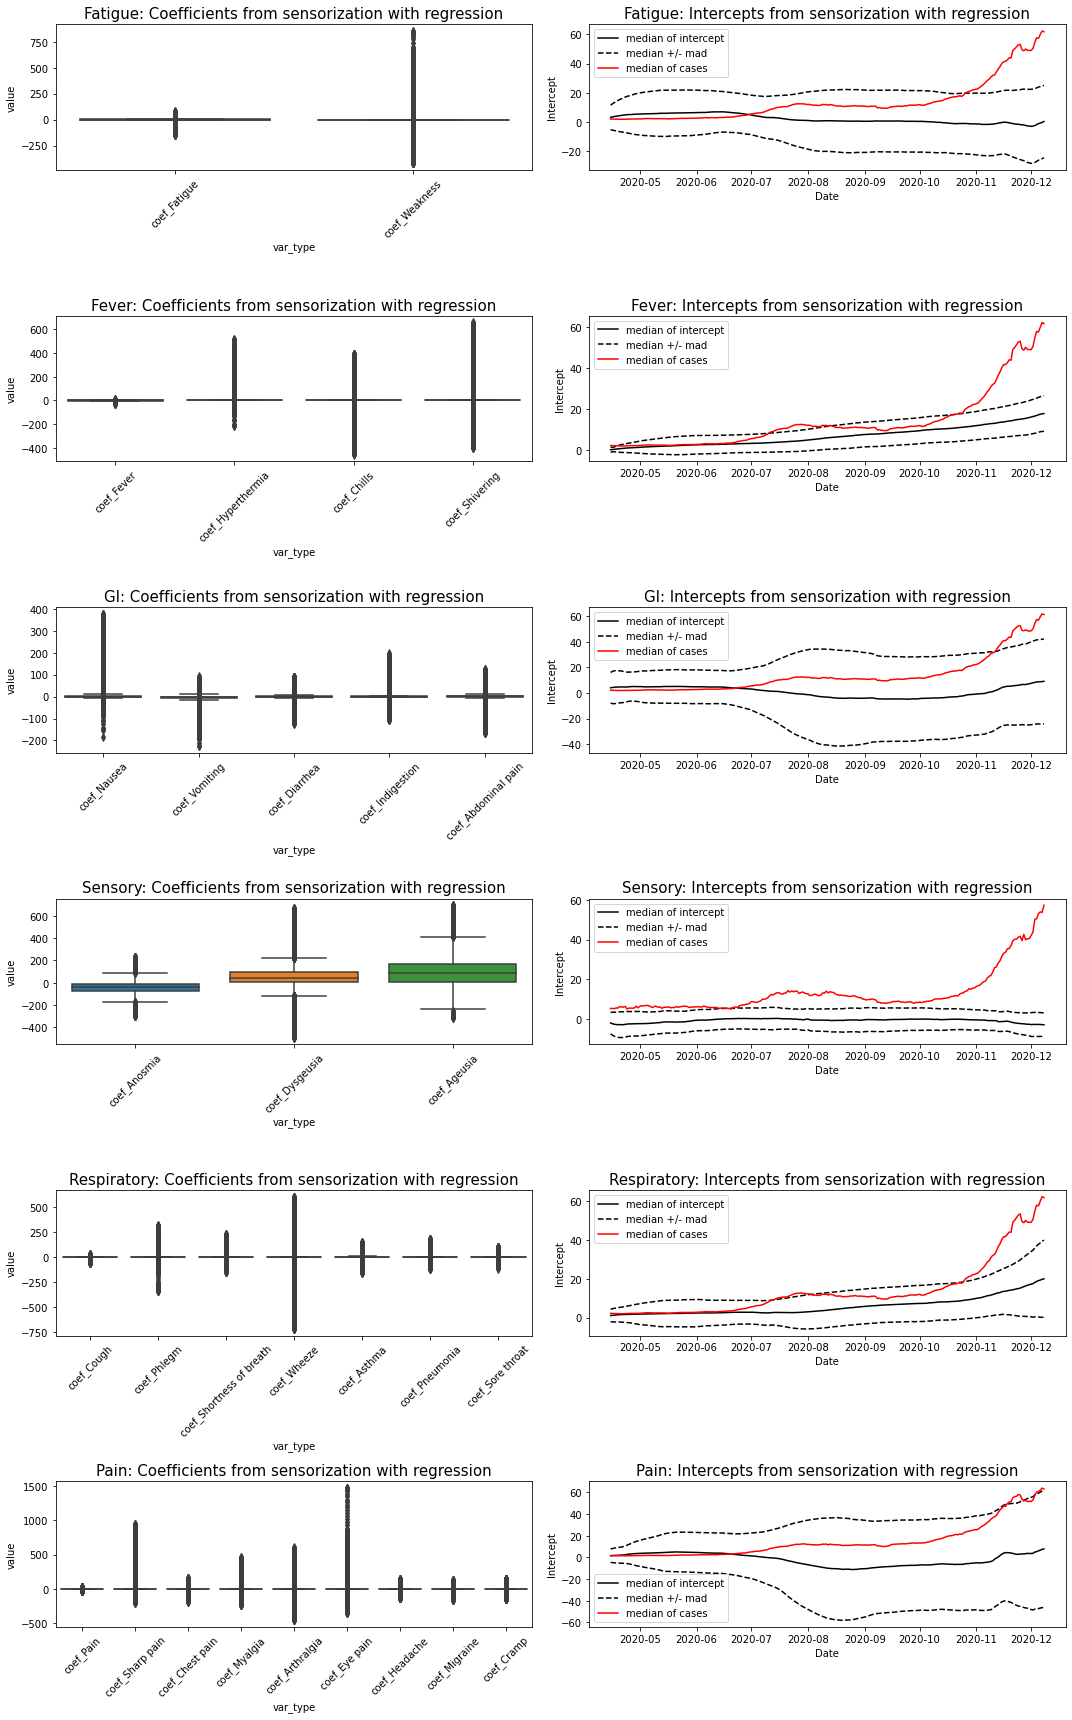

In [80]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize = (15, 24))
i=1
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
for signal in signal_list:
    # Read sensorization result
    df = pd.read_csv("./sensorization_with_as_of/sensored/%s_regression_fill0_sensorization_12_14.csv"%signal,
                    parse_dates=["date"])
    df = df.loc[df["date"] >= datetime(2020, 4, 15)]
    median_df = df.groupby("date").median().reset_index().drop(["geo_id"], axis=1)
    mad_df = df.groupby("date").mad().reset_index().drop(["geo_id"], axis=1)
    summary_df = median_df.merge(mad_df, on="date", suffixes=["_median", "_mad"])
    
    plt.subplot(6, 2, i)
    selected_idx = [j for j in range(df.shape[1]) if "coef" in df.columns[j]]
    trans_df = pd.melt(df, 
                id_vars=list(df.columns[[j for j in range(df.shape[1]) if j not in selected_idx]]), 
                value_vars=list(df.columns[selected_idx]), # list of days of the week
                var_name='var_type', 
                value_name='value')
    sns.boxplot(x="var_type", y="value", data=trans_df)
    plt.title("%s: Coefficients from sensorization with regression"%signal, fontsize=15)
    plt.xticks(rotation=45)
    
    plt.subplot(6, 2, i+1)
    plt.plot(summary_df["date"], summary_df["intercept_median"], color = "black", label="median of intercept")
    plt.plot(summary_df["date"], summary_df["intercept_median"] + summary_df["intercept_mad"], 
             color = "black", linestyle = "--")
    plt.plot(summary_df["date"], summary_df["intercept_median"] - summary_df["intercept_mad"], 
             color = "black", label="median +/- mad", linestyle = "--")
    plt.plot(summary_df["date"], summary_df["cases_median"], color = "red", label="median of cases")
    plt.title("%s: Intercepts from sensorization with regression"%signal, fontsize=15)
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Intercept")
    i+=2
plt.tight_layout()  

### Predictive Power Analysis

For each indicator, we evaluation its predictive power again confirmed case incidence rates provided by USA-Facts following the instruction of Ryan’s forecasting notebook. We perform forecasts for 5 days ahead through 20 days ahead. For each comparison, the number of counties considered remains the same for each indicators. For example, Sensory has only 109 counties available. The predictive power for Doctor Visits and Facebook %CLI are also calculated based on data for those counties only. Since Facebook %CLI is only available for ~1k counties while Pain has data for >2k counties, we only use Doctor Visits for that comparison. **Therefore, the number of counties considered for each subplots is different, but is the same for different indicators whithin a subplot.**

Notice that we takes `as_of` date into consideration when conducting the correlation analysis and we assume that there is a 5-day lag in Google Symptoms dataset which is not the reality. In the predictive power analysis, we adopts the main idea from Ryan's forecasting notebook, but considers varying `as_of` date when computing the predictive error across time by using 14-day moving windows. 

The indicators derived from Sensory symptom sets are competitive as Doctor Visits and Facebook %CLI. The rawsum indicators outperforms most of the other indicators though they have extremely poor geographical coverage. Unfortunately, the indicators derived from other symptom sets does not always beat Doctor Visits and Facebook %CLI. They show worse predictive power compared to case only model if choosing the target to be 5-15 days ahead.

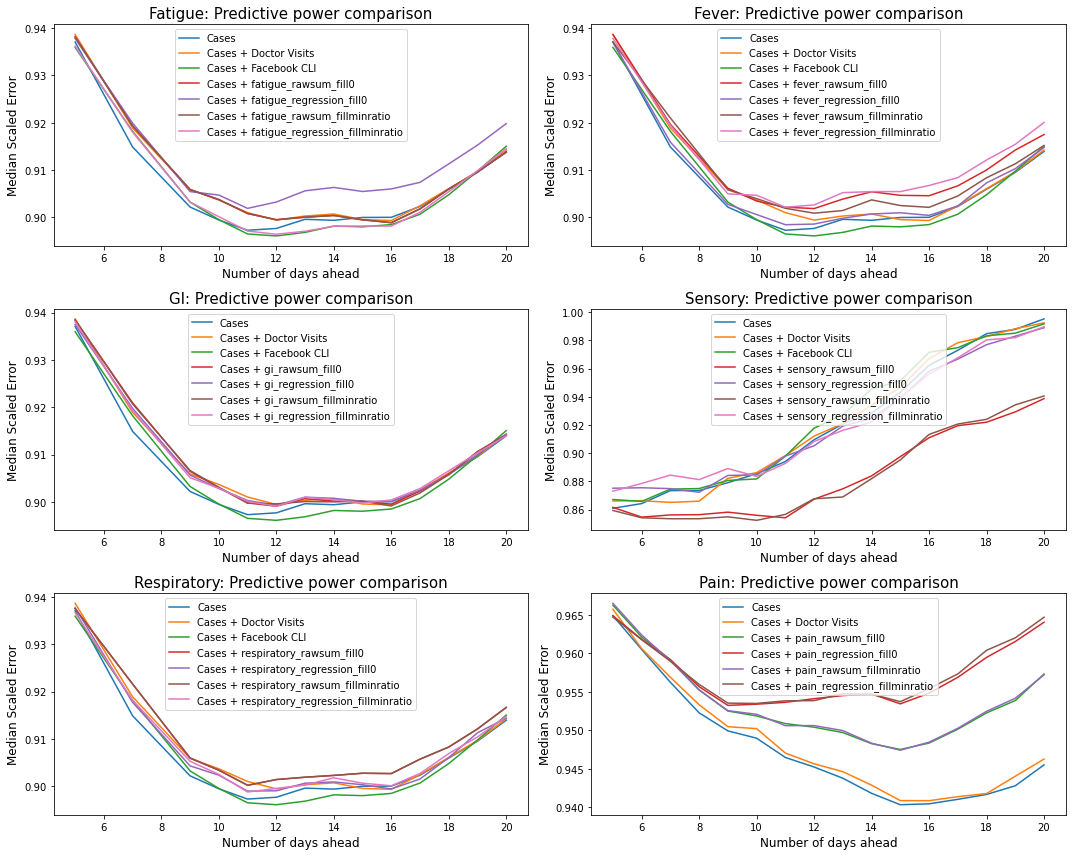

In [79]:
plt.figure(figsize = (15, 12))
i=1
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    try:
        median_pred_df = pd.read_csv("./sensorization_with_as_of/median_err_by_lead/%s_err_by_lead.csv"%signal.lower())
    except:
        continue
    for model in median_pred_df["model"].unique():
        part_df = median_pred_df.loc[median_pred_df["model"] == model].copy()
        plt.plot(part_df["lead"], part_df["err"], label=model)
    plt.legend(loc='upper center')
    plt.xlabel("Number of days ahead", fontsize=12)
    plt.ylabel("Median Scaled Error", fontsize=12)
    plt.title("%s: Predictive power comparison"%signal, fontsize=15)
plt.tight_layout()

# Discussion

Static sensorization theoretically and pratically makes sense for generating new google symptom indicators based on mutiple COVID-related symptoms. According to the analysis and visualization shown above, the choice of methods for filling missing dates does not matter much. Using regressiong in sensorization training step is a good way to combine multiple symptoms but it is computational costly and the benefit is not siginificant. There is a tradeoff between sticking to rawsum or using regression method. 

Though the indicators for different symptom sets have very different geographical coverage, they show great time-wise and geo-wise correlation again the smoothed confirmed case incidence rates (USA-Facts). Since the dataset is not updated by Google daily, we didn't talk anything about backfill problem for this datasets. All the data we used is based on the dataset updated on 2020-12-14. 

# Appendix

### Scatter plots for geo-wise correlation

Sanity check for geo-wise correlation

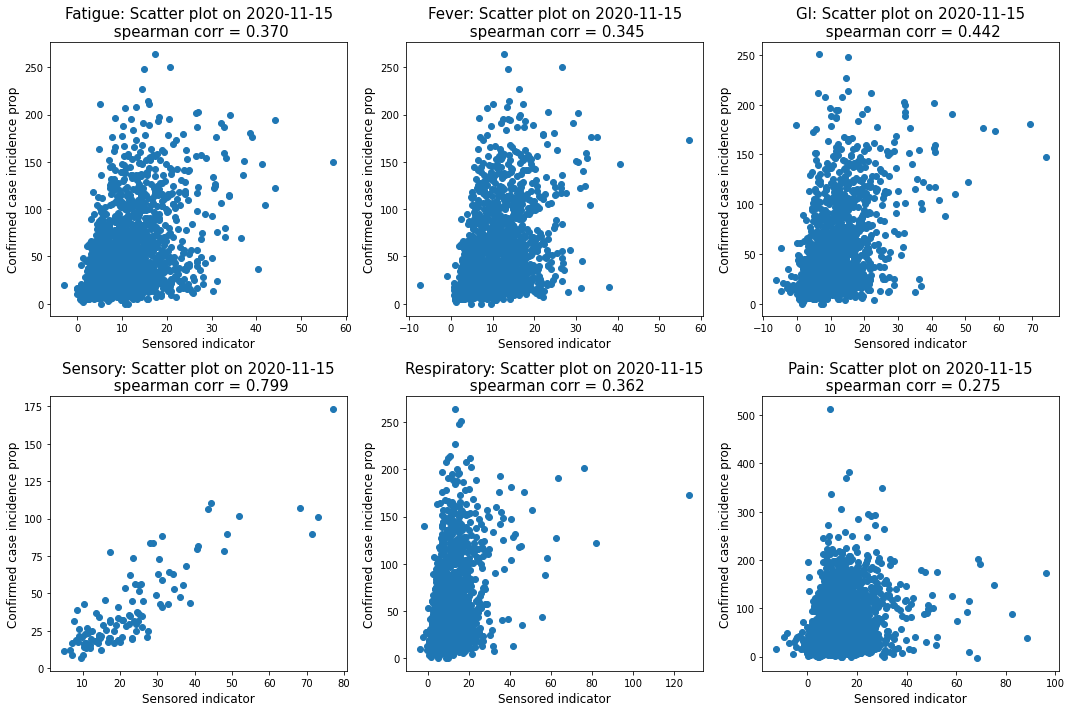

In [37]:
_d = datetime(2020, 11, 15)
method = "regression"
fillmissingness = "fill0"
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]

plt.figure(figsize = (15, 10))
i = 1
for setn in signal_list:
    plt.subplot(2, 3, i)
    i+=1
    df = pd.read_csv("./sensorization_with_as_of/sensored/%s_%s_%s_sensorization_12_14.csv"%(setn, method, fillmissingness), 
                     parse_dates=["date"]).dropna()
    df = df.loc[df["date"] == _d]
    corr = spearmanr(df[["predicted", "cases"]].values,
                              nan_policy="omit")[0]
    plt.title("%s: Scatter plot on 2020-11-15\n spearman corr = %.3f"%(setn, corr), fontsize=15)
    plt.scatter(df["predicted"], df["cases"])
    plt.xlabel("Sensored indicator", fontsize=12)
    plt.ylabel("Confirmed case incidence prop", fontsize=12)
plt.tight_layout()

### Geo-wise correlation using data where as_of = 2020-12-08 for all the points

Data points on a single line have the same as of date. Here we computed the geo-wise correlation using data sensored by models training on all the data on/before 2020-12-01. The same, the methods for filling missingness do not matter much. All the symptom sets except for Sensory show downwards U-shape lines. Compared with the geo-wise correlation plots shown above, as more date available for training, static sensorization will lose the accuracy of early point correction.

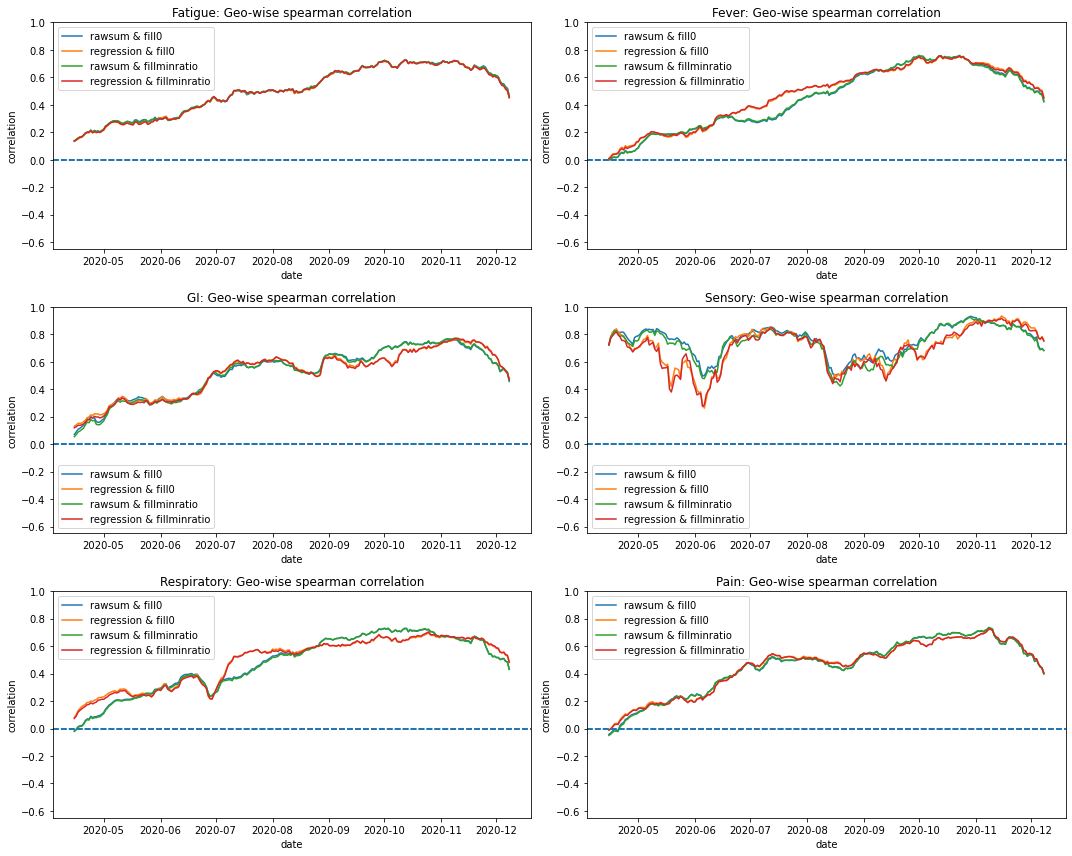

In [13]:
plt.figure(figsize = (15, 12))
i=1
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    for fillmissingness in ["fill0", "fillminratio"]:
        corr_dfs[fillmissingness] = {}
        for method in ["rawsum", "regression"]:
            corr_dfs[fillmissingness][method] = {}        
            corr_dfs[fillmissingness][method][signal] = pd.read_csv("./sensorization_with_as_of/geo_wise_final_as_of/%s_static_geowise_corr_df_%s_%s.csv"%(signal.lower(),
                                                                                            method,
                                                                                            fillmissingness),
                                                                   parse_dates=["date"]) 
            corr_dfs[fillmissingness][method][signal] = corr_dfs[fillmissingness][method][signal].loc[
                corr_dfs[fillmissingness][method][signal]["date"] >= datetime(2020, 4, 15)
            ]
        
            current_df = corr_dfs[fillmissingness][method][signal]
            plt.plot(current_df["date"], current_df["correlation"], label="%s & %s"%(method, fillmissingness))
            plt.title("%s: Geo-wise spearman correlation"%signal)
            plt.ylim((-0.65, 1))
            plt.xlabel("date")
            plt.ylabel("correlation")
            plt.axhline(0, linestyle="--")
            plt.legend()
plt.tight_layout()